In [ ]:
from notebooks import *
print_sys_info()

platform:
  machine: x86_64
  node: ef14631fb25a
  processor: x86_64
  release: 4.14.33+
  system: Linux
  version: '#1 SMP Wed Jun 20 01:15:52 PDT 2018'
cpu: 64
mem: 236g
swap: 0g


In [ ]:
# Load models
load = Load()
projection = Projection.load('peterson-v0-26bae1c', features=Features(load=load))

[01:04:52.113] DEBUG  Projection.load
  path: /app/data/models/projection/peterson-v0-26bae1c.pkl


In [ ]:
# Select recs
#   1. countries: Filter recs to these countries
#   2. com_names: Filter recs to these species
#   3. recs_at_least: Filter species to those with at least this many recs
#   4. num_species: Sample this many of the species
#   5. num_recs: Sample this many recs per species
inf = np.inf
get_recs_stats = lambda df: dict(sp=df.species.nunique(), recs=len(df))
puts_stats = lambda desc: partial(tap, f=lambda df: print('%-15s %12s (sp/recs)' % (desc, '%(sp)s/%(recs)s' % get_recs_stats(df))))
countries, com_names = countries_na, com_names_us  # 9.4/400k -> 1.1k/60k -> 774/53k
# countries, com_names = countries_na, com_names_ca  # 9.4/400k -> 1.1k/60k -> 334/35k
recs_at_least, num_species, num_recs =   0, inf, inf  # US[334/35k ->1.1k/60k -> 774/53k -> 774/53k   -> 743/53k]    # All US
# recs_at_least, num_species, num_recs = 100, 100, 100  # CA[334/35k -> 127/25k -> 100/21k -> 100/10k   -> 100/10k]
# recs_at_least, num_species, num_recs =  50, 100, 100  # CA[334/35k -> 224/32k -> 100/16k -> 100/ 9.0k -> 100/ 9.0k]
# recs_at_least, num_species, num_recs =   0, 100, 100  # CA[334/35k -> 334/35k -> 100/12k -> 100/ 6.8k ->  99/ 6.8k]
# recs_at_least, num_species, num_recs =   0, 168, 100  # CA[334/34k -> 334/34k -> 168/18k -> 168/11k   -> 167/11k]    # (old 'all')
# recs_at_least, num_species, num_recs =   0, 168,  20  # CA[334/34k -> 334/35k -> 168/18k -> 168/ 3.2k -> 167/ 3.2k]  # (old 'recs')
# recs_at_least, num_species, num_recs =  20, 168,  20  # CA[334/35k -> 296/35k -> 168/20k -> 168/ 3.4k -> 168/ 3.4k]  # Familiar set
# recs_at_least, num_species, num_recs =  20, 336,  20  # US[774/53k -> 528/51k -> 336/33k -> 336/ 6.7k -> 336/ 6.7k]  # Scale species
# recs_at_least, num_species, num_recs =  10, 168,  20  # CA[334/35k ->                                             ]  # Class imbalance
# recs_at_least, num_species, num_recs =   0, 168,  20  # CA[334/35k ->                                             ]  # Class imbalance
# recs_at_least, num_species, num_recs =  20, 50,  100  # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,   50  # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,   20  # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,   10  # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,    5  # Faster dev
xcs = (xc.metadata
    .pipe(puts_stats('all'))
    # 1. countries: Filter recs to these countries
    [lambda df: df.country.isin(countries)]
    .pipe(puts_stats('countries'))
    # 2. com_names: Filter recs to these species
    [lambda df: df.com_name.isin(com_names)]
    .pipe(puts_stats('com_names'))
    # Omit not-downloaded recs (should be few within the selected countries)
    [lambda df: df.downloaded]
    .pipe(puts_stats('(downloaded)'))
    # Remove empty cats for perf
    .pipe(df_remove_unused_categories)
    # 3. recs_at_least: Filter species to those with at least this many recs
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= recs_at_least].index)]
    .pipe(puts_stats('recs_at_least'))
    # 4. num_species: Sample this many of the species
    [lambda df: df.species.isin(df.species.drop_duplicates().pipe(lambda s: s.sample(n=min(len(s), num_species), random_state=0)))]
    .pipe(puts_stats('num_species'))
    # 5. num_recs: Sample this many recs per species
    #   - Remove empty cats else .groupby fails on empty groups
    .pipe(df_remove_unused_categories)
    .groupby('species').apply(lambda g: g.sample(n=min(len(g), num_recs), random_state=0))
    .pipe(puts_stats('num_recs'))
    # Drop species with <2 recs, else StratifiedShuffleSplit complains (e.g. 'TUVU')
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= 2].index)]
    .pipe(puts_stats('recs ≥ 2'))
    # Clean up for downstream
    .pipe(df_remove_unused_categories)
)
_recs_stats = get_recs_stats(xcs)
recs_stats = ', '.join(['%s[%s]' % (k, v) for k, v in _recs_stats.items()])
display(
    recs_stats,
    df_summary(xcs).T,
    xcs.sample(n=10, random_state=0).sort_values('species'),
)

all              9442/399859 (sp/recs)
countries         1148/59713 (sp/recs)
com_names          774/52707 (sp/recs)
(downloaded)       774/52697 (sp/recs)
recs_at_least      774/52697 (sp/recs)
num_species        774/52697 (sp/recs)


num_recs           774/52697 (sp/recs)
recs ≥ 2           743/52666 (sp/recs)


'sp[743], recs[52666]'

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
downloaded,bool,1474648,52666,52666,1,NaN,NaN,True,True,True,True,True
species,category,2791371,52666,52666,743,NaN,NaN,BBWD,PIWO,BEWR,ATSP,PTWH
id,int64,1474648,52666,52666,52666,216082.086,111918.665,575,132911,203783,318954,417729
sci_name,category,3538812,52666,52666,744,NaN,NaN,Dendrocygna autumnalis,Dryocopus pileatus,Thryomanes bewickii,Spizella arborea,Vidua macroura
com_name,category,3438075,52666,52666,744,NaN,NaN,Black-bellied Whistling Duck,Pileated Woodpecker,Bewick's Wren,American Tree Sparrow,Pin-tailed Whydah
subspecies,object,2672560,52666,52666,991,NaN,NaN,,,,,zelotes
recordist,object,3319506,52666,52666,930,NaN,NaN,AJ Knue,Fern Hill School,Matt Wistrand,Richard E Webster,Étienne Leroy
country,object,3176875,52666,52666,3,NaN,NaN,Canada,United States,United States,United States,United States
locality,object,4921342,52666,52666,8161,NaN,NaN,"Bangor City Forest, Penobscot County, Maine","Dunn Ave, Victoria, BC","McLellan Park (near Milbridge), Washington County, Maine","Round Valley, Chiricahua Mountains, Cochise Co., Arizona","Álvaro Obregón (near Ciudad de México), Ciudad de México"


,,downloaded,species,id,sci_name,com_name,subspecies,recordist,country,locality,lat,lng,type,quality,date,time,license_type,license_detail,license,url,download
species,,,,,,,,,,,,,,,,,,,,,
HADU,330022,True,HADU,76415,Histrionicus histrionicus,Harlequin Duck,,Andrew Spencer,United States,"Cattle Point, San Juan Island, San Juan Co., Washington",48.5,-123.0,call,B,2011-04-22 00:00:00,12:10,by-nc-nd,2.5,//creativecommons.org/licenses/by-nc-nd/2.5/,https://www.xeno-canto.org/76415,//www.xeno-canto.org/76415/download
HOME,117196,True,HOME,297911,Lophodytes cucullatus,Hooded Merganser,,Paul Marvin,United States,"Viera Wetlands, Florida",28.2,-80.8,call,B,2015-12-29 00:00:00,07:33,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/297911,//www.xeno-canto.org/297911/download
GREG,160230,True,GREG,253851,Ardea alba,Great Egret,,Bobby Wilcox,United States,"Parker, La Paz County, Arizona",34.1,-114.0,"begging call, juvenile",C,2015-05-28 00:00:00,12:30,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/253851,//www.xeno-canto.org/253851/download
BLPH,16471,True,BLPH,401018,Sayornis nigricans,Black Phoebe,semiater,Richard E. Webster,Mexico,"Presa Chiculi, Rio Yaqui, Sonora",27.8,-110.0,song,B,2014-12-12 00:00:00,07:01,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/401018,//www.xeno-canto.org/401018/download
HOLA,384720,True,HOLA,16969,Eremophila alpestris,Horned Lark,,Allen T. Chartier,United States,"Michigan, Monroe County",41.9,-83.5,Song,B,2007-05-07 00:00:00,?,by-nc-sa,3.0,//creativecommons.org/licenses/by-nc-sa/3.0/,https://www.xeno-canto.org/16969,//www.xeno-canto.org/16969/download
CBCH,251415,True,CBCH,159159,Poecile rufescens,Chestnut-backed Chickadee,,Ian Cruickshank,Canada,"Rocky Point Bird Observatory, Metchosin, Vancouver Island, BC",48.3,-124.0,call,no score,2012-08-06 00:00:00,11:33,by-nc-nd,3.0,//creativecommons.org/licenses/by-nc-nd/3.0/,https://www.xeno-canto.org/159159,//www.xeno-canto.org/159159/download
CANW,67815,True,CANW,348664,Catherpes mexicanus,Canyon Wren,,Matt Wistrand,United States,"Garden of the Gods, Colorado Springs, El Paso County, Colorado",38.9,-105.0,call,C,2017-01-01 00:00:00,08:25,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/348664,//www.xeno-canto.org/348664/download
SATH,295964,True,SATH,112652,Oreoscoptes montanus,Sage Thrasher,,Tayler Brooks,United States,"CR 71S N of Maybell, Moffat, Colorado",40.6,-108.0,"alarm call, call",A,2012-05-15 00:00:00,10:00,by-nc-sa,3.0,//creativecommons.org/licenses/by-nc-sa/3.0/,https://www.xeno-canto.org/112652,//www.xeno-canto.org/112652/download
BRSP,223675,True,BRSP,188119,Spizella breweri,Brewer's Sparrow,taverneri,Richard E. Webster,Canada,"Jasper National Park, Division No. 15, Alberta",52.2,-117.0,song,A,2014-06-11 00:00:00,08:55,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/188119,//www.xeno-canto.org/188119/download


In [ ]:
xcs_paths = [
    ('xc', f'{data_dir}/xc/data/{row.species}/{row.id}/audio.mp3')
    for row in df_rows(xcs)
]
joblib.dump(xcs_paths, '/tmp/xcs_paths')  # In case you want to run load.recs in a terminal (it's long and verbose)
display(
    f"{len(xcs_paths)}/{len(xcs)}",
    # xcs_paths[:2],
)

'52666/52666'

In [ ]:
# TODO Restore once:true after debug [but think carefully how once:true interacts with the once:false params above]
recs = load.recs(paths=xcs_paths)
display(
    df_summary(recs).T,
    recs[:5],
)

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
dataset,object,2682804,52604,52604,1,NaN,NaN,xc,xc,xc,xc,xc
species,category,2788085,52604,52604,739,NaN,NaN,BBWD,PIWO,BEWR,ATSP,PTWH
species_com_name,category,3428009,52604,52604,739,NaN,NaN,Black-bellied Whistling-Duck,Pileated Woodpecker,Bewick's Wren,American Tree Sparrow,Pin-tailed Whydah
species_query,object,2788085,52604,52604,739,NaN,NaN,ABDU,CBTH,KAEL,RTHA,yecpar
duration_s,float64,1262496,52604,52604,28499,5.751e+01,9.718e+01,0.209,16.2,34.3,67.8,7.37e+03
samples_mb,float64,1262496,52604,52604,28482,2.436e+00,4.118e+00,0.00879,0.686,1.45,2.87,310
samples_n,int64,1472912,52604,52604,28482,1.277e+06,2.159e+06,4608,359424,759168,1502208,162524221
basename,object,2840616,52604,52604,1,NaN,NaN,audio,audio,audio,audio,audio
species_longhand,category,3796310,52604,52604,739,NaN,NaN,Black-bellied Whistling-Duck - BBWD,Pileated Woodpecker - PIWO,Bewick's Wren - BEWR,American Tree Sparrow - ATSP,Pin-tailed Whydah - PTWH


,dataset,species,species_com_name,species_query,duration_s,samples_mb,samples_n,basename,species_longhand,id,path
0,xc,BBWD,Black-bellied Whistling-Duck,BBWD,22.6,0.952,499036,audio,Black-bellied Whistling-Duck - BBWD,xc/data/BBWD/172907/audio,xc/data/BBWD/172907/audio.mp3
1,xc,BBWD,Black-bellied Whistling-Duck,BBWD,134.0,5.640,2957692,audio,Black-bellied Whistling-Duck - BBWD,xc/data/BBWD/264961/audio,xc/data/BBWD/264961/audio.mp3
2,xc,BBWD,Black-bellied Whistling-Duck,BBWD,25.4,1.070,560952,audio,Black-bellied Whistling-Duck - BBWD,xc/data/BBWD/143613/audio,xc/data/BBWD/143613/audio.mp3
3,xc,BBWD,Black-bellied Whistling-Duck,BBWD,16.7,0.703,368640,audio,Black-bellied Whistling-Duck - BBWD,xc/data/BBWD/317158/audio,xc/data/BBWD/317158/audio.mp3
4,xc,BBWD,Black-bellied Whistling-Duck,BBWD,38.6,1.620,850854,audio,Black-bellied Whistling-Duck - BBWD,xc/data/BBWD/147709/audio,xc/data/BBWD/147709/audio.mp3


In [ ]:
# Fast-and-cheap version (<1s) of the plots below (~7s)
(recs
    .species_longhand.value_counts().sort_index()
    .reset_index().rename(columns={'index': 'species_longhand', 'species_longhand': 'num_recs'})
    .assign(num_recs=lambda df: df.num_recs.map(lambda n: '%s /%s' % ('•' * int(n / df.num_recs.max() * 60), df.num_recs.max())))
)

,species_longhand,num_recs
0,Black-bellied Whistling-Duck - BBWD,•••• /659
1,Fulvous Whistling-Duck - FUWD,• /659
2,Emperor Goose - EMGO,/659
3,Snow Goose - SNGO,••••• /659
4,Ross's Goose - ROGO,/659
5,Greater White-fronted Goose - GWFG,••• /659
6,Brant - BRAN,•• /659
7,Cackling Goose - CACG,••• /659
8,Canada Goose - CANG,•••••••••• /659
9,Hawaiian Goose - HAGO,• /659


In [ ]:
# Num recs loaded for training + total num available [slow: ~7s]
(recs
    .pipe(df_reverse_cat, 'species_longhand')
    .assign(recs_n=1).groupby(['species', 'species_longhand'])['recs_n'].sum().reset_index()
    .set_index('species')
    # [:100]
    .join(how='left', other=(xc.metadata
        .assign(total_n=1).groupby('species')['total_n'].sum().reset_index()
        .set_index('species')
    ))
    .reset_index()
    .pipe(ggplot)
    + aes(x='species_longhand')
    + geom_col(aes(y='total_n'), fill='darkgray')
    + geom_col(aes(y='recs_n'), fill=scale_color_cmap(mpl.cm.tab10).palette(0))
    # + geom_point(aes(y='total_n'), color='darkgray')
    # + geom_point(aes(y='recs_n'), color=scale_color_cmap(mpl.cm.tab10).palette(0))
    + expand_limits(y=0)
    + coord_flip()
    + theme(axis_text_y=element_text(size=4))
    + theme_figsize(width=18, aspect_ratio=3/2)
    + ggtitle('Num recs loaded for training + total num available')
)

[skip]

In [ ]:
# Plot recs with duration [slow: ~7s]
(recs
    .assign(species=lambda df: df.species_longhand)
    .assign(count=1)
    # 0-fill all (species, dataset) combinations to create empty placeholders for missing bars
    .pipe(lambda df: df.append(
        pd.DataFrame([
            dict(species=species, dataset=dataset, duration_s=0)
            for species in df.species.unique()
            for dataset in df.dataset.unique()
        ])
        .astype({'species': df.species.dtype})
    ))
    .groupby(['dataset', 'species'])[['count', 'duration_s']].sum().reset_index()
    # Order by species by taxo
    .pipe(df_reverse_cat, 'species')
    # Order by species by count
    # .pipe(df_ordered_cat, species=lambda df: df.sort_values('count').species)
    .pipe(pd.melt, id_vars=['dataset', 'species'], value_vars=['count', 'duration_s'])
    .pipe(df_remove_unused_categories)
    .pipe(ggplot, aes(x='species', y='value', fill='dataset', color='dataset'))
    + coord_flip()
    + geom_bar(stat='identity', position=position_dodge(), width=.8)
    + facet_wrap('variable', nrow=1, scales='free')
    + xlab('')
    + ylab('')
    + scale_fill_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + theme(panel_spacing=2.5)
    + theme_figsize(width=18, aspect_ratio=4/1)
    + ggtitle(f'recs: Total (count, duration_s) per (species, dataset)')
)

[skip]

In [ ]:
# Add .feat
recs = projection.transform(recs)

In [ ]:
# GridSearchCV many models / model params
#   - Order these roughly from most to least expensive, so that training runs fail fast (e.g. oom at the start, not the end)
param_grid = list(unique_everseen([
    dict(
        classifier=[classifier],
        n_species=[n_species if isinstance(n_species, int) else int(n_species * _recs_stats['sp'])],
        n_recs=[
            # n_recs if isinstance(n_recs, int) else int(n_recs * _recs_stats['recs']),
            # TODO Figure out how to represent this as an n instead of a frac again [TODO interaction with test_size=.2 ...]
            #   - TODO Also make clear in the plot descs when e.g. (recs[3360], n_species[33], n_recs[1.0]) -> n_recs[33*20 < 3360]
            n_recs,
        ],
    )
    for (n_species, n_recs) in [
        # Subset for learning curves
        #   - Biggest first, to fail fast

        # (None, None),

        # Quick wins
        # (0.01, 0.01),

        # # Scale species
        (0.25, 1.00),
        (0.50, 1.00),
        (1.00, 1.00),

        # # Scale data
        (1.00, 0.25),
        (1.00, 0.50),
        (1.00, 1.00),

        # (1.00, 1.00),
        # (1.00, 0.50),
        # (0.50, 1.00),

        # Faster dev
        # (0.10, 0.10),

    ]
    # model_size ~ forest_depth
    for rf_mean_depth_at_168_sp in [
        93.5,
    ]
    for rf_max_depth in [
        'null',
        int(rf_mean_depth_at_168_sp * n_species * 1),
        int(rf_mean_depth_at_168_sp * n_species * 3/4),
        int(rf_mean_depth_at_168_sp * n_species * 1/2),
        int(rf_mean_depth_at_168_sp * n_species * 1/3),
        int(rf_mean_depth_at_168_sp * n_species * 1/4),
        int(rf_mean_depth_at_168_sp * n_species * 1/8),
        5,
        4,
        3,
        2,
        1,
    ]
    # for ovr_rf_max_depth in [int(rf_max_depth / 10) if rf_max_depth != 'null' else 'null']
    # for xgb_rf_max_depth in [lambda x: x if x != 'null' else 100]
    for ovr_rf_max_depth in [
        # 'null',
        46,
        35,
        5,
        4,
        3,
        2,
        1,
    ]
    for xgb_rf_max_depth_f in [lambda x: x if x != 'null' else 100]
    for xgb_rf_max_depth in [
        # xgb_rf_max_depth_f(rf_max_depth),
        xgb_rf_max_depth_f(ovr_rf_max_depth),
    ]
    for rf_n_estimators in [
        # 2000, 1500,  # WARNING Not mem safe on laptop
        100,
        # 50, 25,  # TODO Train
    ]
    for xgb_rf_n_estimators in [
        1600, 400,
        100,
        # 50, 25,
    ]
    for ovr_rf_n_estimators in [
        100,
        # 50, 25,
    ]
    for logreg_cls, logreg_solver in [
        # ('logreg_multi', 'newton-cg'),  # Similar acc to ('logreg_ovr', 'liblinear') but ~2-10x slower to train
        ('logreg_ovr', 'liblinear'),
        # ('ovr-logreg_ovr', 'liblinear'),
        ('logreg_ovr', 'saga'),
        ('logreg_multi', 'saga'),
    ]
    for logreg_max_iter in (
        [None] if logreg_solver not in ['saga'] else [
            # 100,
            # 200,
            # 400,
            # 800,
            # 1600,
            3200,
            # 6400,
            # 12800,
        ]
    )
    for logreg_C in [
        # 1/reg_strength: C=inf is no regularization, smaller C is more regularization (default: 1)
        # Default: 1; inf is no regular
        # 1,
        # .01, .1, 1,
        .01, 1, 100,
        # .001, .01, .1, 1, 10, 100,
    ]
    for logreg_class_weight in [
        None,
        'balanced',  # No (visually) significant effect with class sizes 0-20 (see class_imbalance notebooks)
    ]
    for classifier in [

        # Naive Bayes
        'cls: nb',

        # RF
        # f'cls: rf, n_estimators: {rf_n_estimators}, max_depth: {rf_max_depth}',
        # f'cls: ovr-rf, n_estimators: {ovr_rf_n_estimators}, max_depth: {ovr_rf_max_depth}',
        f'cls: xgb_rf, n_estimators: {xgb_rf_n_estimators}, max_depth: {xgb_rf_max_depth}',

        # Logistic regression
        ','.join(x for x in [
            f'cls: {logreg_cls}',
            f'solver: {logreg_solver}',
            '' if logreg_max_iter is None else f'max_iter: {logreg_max_iter}',
            f'C: {logreg_C}',
            '' if logreg_class_weight is None else f'class_weight: {logreg_class_weight}',
        ] if x),

    ]
]))

# TODO Increase cv to decrease variance in eval metrics (this made Alex extremely squirmy)
cv = GridSearchCVCached(
    estimator=Search(projection=projection),
    param_grid=param_grid,
    refit=False,  # Don't spend time fitting cv.best_estimator_ at the end (default: True)
    # cv=3,  # [SP14] uses two-/three-fold CV [why?]
    # Stratified ensures that all classes have >0 instances in each split, which is statistically maybe fishy but avoids
    # breaking various code that merges the split results back together and assumes all splits' classes are the same
    cv=sk.model_selection.StratifiedShuffleSplit(
        n_splits=1,  # [for ~18/20 miss: ~19m, ~16g disk cache]
        # n_splits=2,
        # n_splits=3,
        # n_splits=5,
        # n_splits=10,
        # n_splits=20,  # Known good [>51m uncached, >25g disk cache]
        # n_splits=100,  # [?m runtime, ?g disk cache]
        test_size=.2,
        random_state=0,
    ),
    return_train_score=True,
    # return_estimator=True,  # Verrrry heavy, use extra_metrics instead
    # recompute_extra_metrics=True,  # Loads estimator.pkl (fast) but doesn't return it (huge)
    extra_metrics=dict(
        # [How to specify SearchEvals here without creating caching headaches?]
        #   - e.g. defs don't bust cache on code edit
        #   - And avoid thrashing cache every time we refactor SearchEvals
        classes='estimator.classes_',
        train_i='train',
        train_y='y_train',
        train_predict_proba='estimator.classifier_.predict_proba(X_train)',
        test_i='test',
        test_y='y_test',
        test_predict_proba='estimator.classifier_.predict_proba(X_test)',
        model_size='len(joblib_dumps(estimator))',
        model_stats='model_stats(estimator)',
        proc_stats='proc_stats',
    ),
    # verbose=10,  # O(models * n_splits) lines of outputs
    verbose=1,  # O(1) lines of outputs
    # Use n_jobs=1
    #   - All classifiers can parallelize .fit/.predict
    #   - Avoid memory contention
    # n_jobs=-1,
    # n_jobs=1,  # For %prun, and way faster for 100% loads
    # n_jobs=2,
    # n_jobs=4,
    # n_jobs=6,  # For exactly 6 models
    # n_jobs=8,  # For slow ovr serdes [why?]
    # TODO TODO Manually tune n_jobs to saturate 64 cores, while ensuring that some jobs finish in ~short durations for incrementalism
    # n_jobs=8,  # Too many 1-core liblinears, ~25% overall cpu utilization
    n_jobs=16,
    # n_jobs=32,  # ~45 jobs launch, many procs only getting ~25% cpu
    artifacts=dict(
        dir=f'{data_dir}/artifacts',  # TODO Iron out syncing across local/gs/remote
        save=True,
        reuse='20180709-211727-fd34af5-ovr_try_2',
        # skip_compute_if_missing=True,  # TODO Tricky to implement: _fit_and_score_cached needs to be able to return nothing
    ),
)
with contextlib.ExitStack() as stack:
    # stack.enter_context(cache_control(refresh=True))  # Disk unsafe...
    stack.enter_context(cache_control(enabled=False))  # Disk safe
    # stack.enter_context(joblib.parallel_backend('threading'))  # Default: 'multiprocessing'
    # stack.enter_context(joblib.parallel_backend('sequential'))  # For %prun [FIXME Has no effect; why?]
    stack.enter_context(log.context(level='info'))
    # stack.enter_context(log.context(level='debug'))
    X, y = Search.Xy(recs)
    cv.fit(X, y)

Fitting 1 folds for each of 200 candidates, totalling 200 fits
[01:17:45.601] INFO   artifacts
  dir: /app/data/artifacts
  save: true
  reuse: 20180709-211727-fd34af5-ovr_try_2
  experiment_id: 20180709-211727-fd34af5-ovr_try_2


[01:17:47.588] INFO   _fit_and_score: n[1/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=nb',random_state=0)]: fit...


[01:17:48.181] INFO   _fit_and_score: n[2/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=xgb_rf,n_estimators=1600,max_depth=46',random_state=0)]: fit...


[01:17:48.774] INFO   _fit_and_score: n[3/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01',random_state=0)]: fit...


[01:17:49.367] INFO   _fit_and_score: n[4/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01,class_weight=balanced',random_state=0)]: fit...


[01:17:49.957] INFO   _fit_and_score: n[5/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1',random_state=0)]: fit...


[01:17:50.550] INFO   _fit_and_score: n[6/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1,class_weight=balanced',random_state=0)]: fit...


[01:17:51.143] INFO   _fit_and_score: n[7/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=100',random_state=0)]: fit...


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[01:17:51.738] INFO   _fit_and_score: n[8/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=100,class_weight=balanced',random_state=0)]: fit...


[01:17:52.331] INFO   _fit_and_score: n[9/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=logreg_ovr,solver=saga,max_iter=3200,C=0.01',random_state=0)]: fit...


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[01:17:52.923] INFO   _fit_and_score: n[10/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=logreg_ovr,solver=saga,max_iter=3200,C=0.01,class_weight=balanced',random_state=0)]: fit...


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[01:17:53.514] INFO   _fit_and_score: n[11/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=logreg_ovr,solver=saga,max_iter=3200,C=1',random_state=0)]: fit...


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[01:17:54.108] INFO   _fit_and_score: n[12/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=logreg_ovr,solver=saga,max_iter=3200,C=1,class_weight=balanced',random_state=0)]: fit...


[01:17:54.699] INFO   _fit_and_score: n[13/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=logreg_ovr,solver=saga,max_iter=3200,C=100',random_state=0)]: fit...


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[01:17:55.291] INFO   _fit_and_score: n[14/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=logreg_ovr,solver=saga,max_iter=3200,C=100,class_weight=balanced',random_state=0)]: fit...


[01:17:55.885] INFO   _fit_and_score: n[15/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=logreg_multi,solver=saga,max_iter=3200,C=0.01',random_state=0)]: fit...


[01:17:56.478] INFO   _fit_and_score: n[16/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=logreg_multi,solver=saga,max_iter=3200,C=0.01,class_weight=balanced',random_state=0)]: fit...


[01:17:57.077] INFO   _fit_and_score: n[17/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=logreg_multi,solver=saga,max_iter=3200,C=1',random_state=0)]: fit...


[01:17:57.686] INFO   _fit_and_score: n[18/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=logreg_multi,solver=saga,max_iter=3200,C=1,class_weight=balanced',random_state=0)]: fit...


[01:17:58.303] INFO   _fit_and_score: n[19/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=logreg_multi,solver=saga,max_iter=3200,C=100',random_state=0)]: fit...


[01:17:58.956] INFO   _fit_and_score: n[20/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=logreg_multi,solver=saga,max_iter=3200,C=100,class_weight=balanced',random_state=0)]: fit...


[01:17:59.566] INFO   _fit_and_score: n[21/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=xgb_rf,n_estimators=400,max_depth=46',random_state=0)]: fit...


[01:18:00.232] INFO   _fit_and_score: n[22/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=xgb_rf,n_estimators=100,max_depth=46',random_state=0)]: fit...


[01:18:00.908] INFO   _fit_and_score: n[23/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=xgb_rf,n_estimators=1600,max_depth=35',random_state=0)]: fit...


[01:18:01.585] INFO   _fit_and_score: n[24/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=xgb_rf,n_estimators=400,max_depth=35',random_state=0)]: fit...


[01:18:02.262] INFO   _fit_and_score: n[25/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=xgb_rf,n_estimators=100,max_depth=35',random_state=0)]: fit...


[01:18:02.980] INFO   _fit_and_score: n[26/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=xgb_rf,n_estimators=1600,max_depth=5',random_state=0)]: fit...


[01:18:03.714] INFO   _fit_and_score: n[27/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=xgb_rf,n_estimators=400,max_depth=5',random_state=0)]: fit...


[01:18:04.415] INFO   _fit_and_score: n[28/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=xgb_rf,n_estimators=100,max_depth=5',random_state=0)]: fit...


[01:18:05.128] INFO   _fit_and_score: n[29/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=xgb_rf,n_estimators=1600,max_depth=4',random_state=0)]: fit...


[01:18:05.842] INFO   _fit_and_score: n[30/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=xgb_rf,n_estimators=400,max_depth=4',random_state=0)]: fit...


[01:18:06.541] INFO   _fit_and_score: n[31/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=xgb_rf,n_estimators=100,max_depth=4',random_state=0)]: fit...


[01:18:07.231] INFO   _fit_and_score: n[32/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=xgb_rf,n_estimators=1600,max_depth=3',random_state=0)]: fit...


[01:18:07.852] INFO   _fit_and_score: n[33/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=xgb_rf,n_estimators=400,max_depth=3',random_state=0)]: fit...


[01:18:08.577] INFO   _fit_and_score: n[34/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=xgb_rf,n_estimators=100,max_depth=3',random_state=0)]: fit...


[01:18:09.273] INFO   _fit_and_score: n[35/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=xgb_rf,n_estimators=1600,max_depth=2',random_state=0)]: fit...


[01:18:09.895] INFO   _fit_and_score: n[36/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=xgb_rf,n_estimators=400,max_depth=2',random_state=0)]: fit...


[01:18:10.618] INFO   _fit_and_score: n[37/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=xgb_rf,n_estimators=100,max_depth=2',random_state=0)]: fit...


[01:18:11.235] INFO   _fit_and_score: n[38/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=xgb_rf,n_estimators=1600,max_depth=1',random_state=0)]: fit...


[01:18:11.930] INFO   _fit_and_score: n[39/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=xgb_rf,n_estimators=400,max_depth=1',random_state=0)]: fit...


[01:18:12.643] INFO   _fit_and_score: n[40/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=xgb_rf,n_estimators=100,max_depth=1',random_state=0)]: fit...


[01:18:13.384] INFO   _fit_and_score: n[41/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=371,n_recs=1.0,classifier='cls=nb',random_state=0)]: fit...


[01:18:14.604] INFO   _fit_and_score: n[42/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=371,n_recs=1.0,classifier='cls=xgb_rf,n_estimators=1600,max_depth=46',random_state=0)]: fit...


[01:18:16.113] INFO   _fit_and_score: n[43/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=371,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01',random_state=0)]: fit...


[01:18:18.187] INFO   _fit_and_score: n[44/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=371,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=0.01,class_weight=balanced',random_state=0)]: fit...


[01:18:20.780] INFO   _fit_and_score: n[45/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=371,n_recs=1.0,classifier='cls=logreg_ovr,solver=liblinear,C=1',random_state=0)]: fit...


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


[01:20:00.060] INFO   _fit_and_score: n[10/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=logreg_ovr,solver=saga,max_iter=3200,C=0.01,class_weight=balanced',random_state=0)]: fit[126.747s]


[01:20:00.082] INFO   _fit_and_score: n[19/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=logreg_multi,solver=saga,max_iter=3200,C=100',random_state=0)]: fit[121.272s]


[01:20:00.081] INFO   _fit_and_score: n[15/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=logreg_multi,solver=saga,max_iter=3200,C=0.01',random_state=0)]: fit[123.793s]


[01:20:00.099] INFO   _fit_and_score: n[18/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=logreg_multi,solver=saga,max_iter=3200,C=1,class_weight=balanced',random_state=0)]: fit[121.930s]


[01:20:00.098] INFO   _fit_and_score: n[14/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=logreg_ovr,solver=saga,max_iter=3200,C=100,class_weight=balanced',random_state=0)]: fit[124.407s]


[01:20:00.133] INFO   _fit_and_score: n[16/200], model_id[split_i=0,train=42083,test=10521,classes=739,estimator=Search(n_species=185,n_recs=1.0,classifier='cls=logreg_multi,solver=saga,max_iter=3200,C=0.01,class_weight=balanced',random_state=0)]: fit[123.241s]


KeyboardInterrupt: 

In [ ]:
# Precompute eval metrics + dims for the plots below
#   - Grain: models
#   - Metrics: train_score, test_score, ...
#   - Dims: model_id, fold, params_data, params_complexity, params_model, ...
facet = (
    facet_wrap('params_data_and_model')
    # facet_grid('params_data ~ params_model')
    # facet_grid('params_model ~ params_data')
    # facet_grid('n_recs ~ n_species', labeller='label_both')
)
ks_params_data = [
    'n_species',
    'n_recs',
]
ks_params_complexity = [
    # 'c_n_estimators',
    'c_max_depth',
    'c_C',
    # 'c_class_weight',
]
# params_model = ...  # Everything else
# log.debug('Start')
cv_models = (cv_results_splits_df(cv.cv_results_)
    # Slow yaml parsing, compute up front
    .assign(params_dict=lambda df: df.apply(axis=1, func=lambda row: dict(
        **{strip_startswith(k, 'param_'): row[k] for k in df if k.startswith('param_') and k not in ['param_classifier']},
        # HACK 'classifier.foo' -> 'c_foo'
        #   - TODO Refactor Search.classifier to get rid of the yaml strs ('c_cls', 'c_n_estimators', ...)
        **{'c_' + k: v for k, v in yaml.safe_load('{%s}' % row.param_classifier).items()},
        # 'classifier': yaml.safe_load('{%s}' % row.param_classifier),
    )))
    [lambda df: [c for c in df if not c.startswith('param_')]]
    # Dims from params (for validation curves, learning curves, etc.)
    .assign(
        n_species=lambda df: df.params_dict.apply(lambda d: d['n_species']),
        n_recs=lambda df: df.params_dict.apply(lambda d: d['n_recs']),
        params_data=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k, d[k]) for k in ks_params_data if k in d
        )),
        params_complexity=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k, d[k]) for k in ks_params_complexity if k in d
        )),
        params_model=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k, d[k]) for k in d if k not in ks_params_data + ks_params_complexity
        )),
        params_data_and_model=lambda df: df.apply(axis=1, func=lambda row: (
            '\n'.join([row.params_data, row.params_model])
        )),
        params_model_and_complexity=lambda df: df.apply(axis=1, func=lambda row: (
            '\n'.join([row.params_model, row.params_complexity])
        )),
    )
    # HACK Convert yaml strs ('x: y') to bracket style ('x[y]'), for visual consistency
    #   - TODO Refactor Search.classifier to get rid of the yaml strs ('c_cls', 'c_n_estimators', ...)
    .applymap(lambda x: x if not isinstance(x, str) else (
        re.sub(r'([^][:, ]+):\s+([^][:,]+)(, )?', r'c_\1[\2]\3',
            re.sub(r'classifier\[([^]]+)\]', r'\1',
                x,
            ),
        )
    ))
    #   - Restore the cats we just destroyed [copied from cv_results_splits_df]
    .pipe(df_ordered_cat,
        model_id=lambda df: df.model_id.unique(),
        params=lambda df: df.params.unique(),
        params_data=lambda df: df.params_data.unique(),
        # Order params_complexity like c_max_depth
        params_complexity=lambda df: sorted(
            df.params_complexity.unique(),
            reverse=True,  # Match how the normal .unique() would come out (not clear why, and don't care)
            key=lambda s: one(
                (x['name'], or_else(-np.inf, lambda: float({'None': 'inf'}.get(x['value'], x['value']))))
                for x in [
                    parse.search('{name}[{value}]', s) or  # Parses first match, ignores rest
                    {'name': 'unk', 'value': None}
                ]
            ),
        ),
        params_model=lambda df: df.params_model.unique(),
    )
    .pipe(df_ordered_cat,
        params_data_and_model=lambda df: (df
            .sort_values(['params_data', 'params_model']).params_data_and_model.unique()
        ),
        params_model_and_complexity=lambda df: (df
            .sort_values(['params_model', 'params_complexity']).params_model_and_complexity.unique()
        ),
    )
    # .eval
    .assign(
        train_evals=lambda df: np.vectorize(SearchEvals)(
            i=df.pop('train_i'),
            y=df.pop('train_y'),
            classes=df['classes'],
            y_scores=df.pop('train_predict_proba'),
            drop_missing_classes_for_n_species=True,  # HACK Migrate to sk Pipeline to avoid this
        ),
        test_evals=lambda df: np.vectorize(SearchEvals)(
            i=df.pop('test_i'),
            y=df.pop('test_y'),
            classes=df['classes'],
            y_scores=df.pop('test_predict_proba'),
            drop_missing_classes_for_n_species=True,  # HACK Migrate to sk Pipeline to avoid this
        ),
    )
    # .pipe(tap, f=lambda df: log.debug('SearchEvals.score'))
    .assign(
        # HACK Recompute (train_score, test_score) using SearchEvals.score so it can drop_missing_classes_for_n_species
        #   - Else you'll get scores that are too low (bad) because they include some -np.inf's in the median
        train_score=lambda df: df.train_evals.map(lambda x: x.score()),
        test_score=lambda df: df.test_evals.map(lambda x: x.score()),  # (= 50p)
        test_75p_score=lambda df: df.test_evals.map(lambda x: x.score(agg=partial(np.percentile, q=75))),
        test_95p_score=lambda df: df.test_evals.map(lambda x: x.score(agg=partial(np.percentile, q=95))),
        # train_score=lambda df: map_progress(lambda x: x.score(), df.train_evals, use='dask', scheduler='threads'),
        # test_score=lambda df: map_progress(lambda x: x.score(), df.test_evals, use='dask', scheduler='threads'),
    )
    .drop(columns=[
        'classes',
    ])
    # proc_stats
    # .pipe(tap, f=lambda df: log.debug('proc_stats'))
    .pipe(lambda df: df.join(df
        .apply(axis=1, func=lambda row: (row.proc_stats.stats
            .groupby('pid')[['cpu_user', 'cpu_system', 'mem_rss', 'mem_vms']].agg(lambda g: g.max() - g.min())
            .sum(axis=0)
        ))
        .rename(columns={
            'cpu_user': 'cpu_user_time',
            'cpu_system': 'cpu_system_time',
            'mem_rss': 'mem_rss_delta',
            'mem_vms': 'mem_vms_delta',
        })
    ))
    .assign(
        cpu_time=lambda df: df.cpu_user_time + df.cpu_system_time,
        cpu_time_m=lambda df: df.cpu_time / 60,  # s -> m
    )
    # For xgb_rf, rf, ovr-rf
    .assign(
        c_multiclass=lambda df: df.params_dict.str.get('c_multiclass'),
        c_max_depth=lambda df: df.params_dict.str.get('c_max_depth'),
        # c_rf_max_depth=lambda df: df.apply(axis=1, func=lambda row: (
        #     row['c_max_depth'] * (10 if row['c_multiclass'] == 'ovr' else 1)  # HACK Undo rf_max_depth -> ovr_rf_max_depth
        # )),
    )
    # model_stats
    .assign(
        logreg_n_iter=lambda df: df.model_stats.map(lambda stats: or_else(None, lambda: stats.n_iter)),
        forest_depth_mean=lambda df: df.model_stats.map(lambda stats: or_else(None, lambda: stats.depth.mean())),
        forest_depth_std=lambda df: df.model_stats.map(lambda stats: or_else(None, lambda: stats.depth.std())),
    )
    # Reorder
    .pipe(df_reorder_cols,
        first=['model_id', 'params', 'params_dict', 'params_data', 'params_complexity', 'params_model'],
        last=['train_evals', 'test_evals', 'proc_stats', 'model_stats', 'model'],
    )
    # .pipe(tap, f=lambda df: log.debug('display'))
    .pipe(tap, f=lambda df: display(
        # df_summary(df).T,
        # df,
        len(df),
        df[:5],
    ))
    # .pipe(tap, f=lambda df: log.debug('Done'))
)

AttributeError: 'GridSearchCVCached' object has no attribute 'cv_results_'

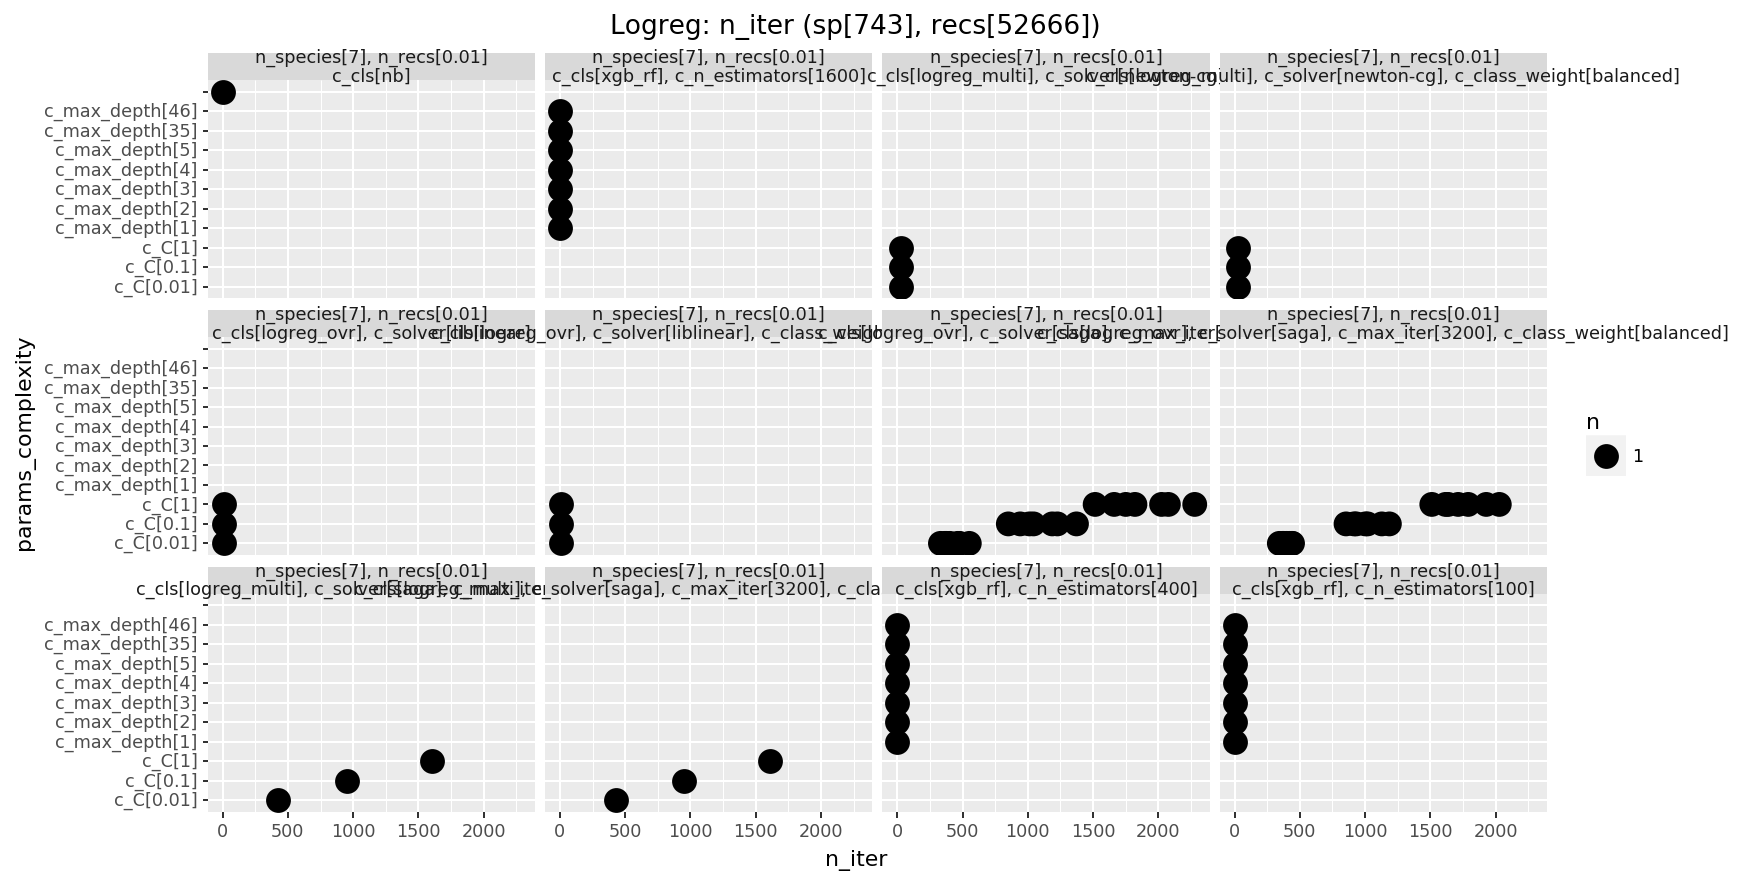

<ggplot: (-9223363290298349084)>

In [ ]:
# Tune logreg n_iter
(cv_models
    .merge(how='left', on='model_id', right=df_flatmap(cv_models, lambda row: (
        dict(model_id=row.model_id, n_iter=n_iter)
        for n_iter in coalesce(row.logreg_n_iter, [0])
    )))
    # Manually compute y.mean() per group
    # .groupby('params').apply(lambda g: g.assign(cpu_time_m_mean=lambda df: df.cpu_time_m.mean()))
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity')
    + facet
    + geom_count(aes(y='n_iter', size='..n..')) + scale_size_area()
    + expand_limits(y=0)
    + coord_flip()
    + theme_figsize(width=12*1, aspect_ratio=1/1.5)
    + ggtitle(f'Logreg: n_iter ({recs_stats})')
)

In [ ]:
# Train time ~ n_species
(cv_models
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='n_species', y='cpu_time_m', color='params_complexity')
    + facet
    # + facet_wrap('params_model', nrow=1)
    + geom_point()
    + geom_line()
    + theme_figsize(width=12*1, aspect_ratio=1/1.5)
    + ggtitle(f'Train time ~ n_species ({recs_stats})')
)
% {time: 2.171s}

UsageError: Line magic function `%{time:` not found.


In [ ]:
# Train time ~ n_recs
(cv_models
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='n_recs', y='cpu_time_m', color='params_complexity')
    + facet
    # + facet_wrap('params_model', nrow=1)
    + geom_point()
    + geom_line()
    + theme_figsize(width=12*1, aspect_ratio=1/1.5)
    + ggtitle(f'Train time ~ n_recs ({recs_stats})')
% {time: 2.928s}


SyntaxError: invalid syntax (<ipython-input-95-fd161920859d>, line 12)

In [ ]:
(cv_models
    # Manually compute y.mean() per group
    .groupby('params').apply(lambda g: g.assign(cpu_time_m_mean=lambda df: df.cpu_time_m.mean()))
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity')
    + facet
    + geom_col(aes(y='cpu_time_m_mean'), fill='darkgray', position=position_dodge())
    + geom_point(aes(y='cpu_time_m'), color='black', fill='none', size=2)
    + coord_flip()
    + theme_figsize(width=12*1, aspect_ratio=1/1.5)
% {time: 3.017s}
   + ggtitle(f'Train + score times ({recs_stats})')
)

SyntaxError: invalid syntax (<ipython-input-96-442de479be38>, line 12)

In [ ]:
(cv_models
    # Manually compute y.mean() per group
    .groupby('params').apply(lambda g: g.assign(model_size_mean=lambda df: df.model_size.mean()))
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity')
    + facet
    + geom_col(aes(y='model_size_mean'), fill='darkgray', position=position_dodge()) # Summary per fold
    + geom_point(aes(y='model_size'), color='black', fill='none', size=2) # Distribution of folds
    + scale_y_continuous(labels=labels_bytes(), breaks=breaks_bytes())
    + coord_flip()
    + ylab('model_size')
% {time: 3.734s}
   + theme_figsize(width=12*1, aspect_ratio=1/1.5)
    + ggtitle(f'Model size ({recs_stats})')
)

SyntaxError: invalid syntax (<ipython-input-97-2120b08f47c1>, line 13)

In [ ]:
# TODO Make not barf on non-tree models (blocks rest of notebook)
(cv_models
    # Manually compute boxplot stats, else it's _really_ slow (or you have to downsample, which misses outliers)
    #   - Based on stat_boxplot.compute_group
    .merge(how='left', on='params', right=cv_models.groupby('params').apply(lambda g: one(
        pd.Series(dict(
            params=g.name,
            ymin=boxplot['whislo'],
            lower=boxplot['q1'],
            middle=boxplot['med'],
            upper=boxplot['q3'],
            ymax=boxplot['whishi'],
            outliers=np.unique(boxplot['fliers']),  # np.unique else really slow, because lots of repeated (int) points
        ))
        for [boxplot] in [mpl.cbook.boxplot_stats(  # [boxplot] is 1 elem because X.ndim = 1
            X=np.concatenate([coalesce(x, {}).get('depth', []) for x in g.model_stats]),
            whis=1.5,
        )]
    )))
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity')
    + facet
    + geom_boxplot(
        stat='identity',
        outlier_size=.5,
        mapping=aes(ymin='ymin', ymax='ymax', upper='upper', lower='lower', middle='middle', outliers='outliers',
            width=.8,  # Close enough to geom_boxplot defaults [TODO Maybe should compute based on num categorical x's?]
        ),
    )
    + ylab('tree_depth')
% {time: 3.211s}
   + coord_flip()
    + theme_figsize(width=12*2, aspect_ratio=1/1.5)
    + ggtitle(f'Tree depth ({recs_stats})')
)

SyntaxError: invalid syntax (<ipython-input-98-d8dfc673b202>, line 32)

In [ ]:
# Train/test scores
#   - Grain: models x {train,test}
#   - Metrics: score
#   - Dims: group, params
(cv_models
    .pipe(df_reverse_cat, 'params_complexity')
    .pipe(lambda df: pd.melt(df,
        id_vars=[
            'params', 'params_data', 'params_model', 'params_complexity',
            'params_data_and_model', 'params_model_and_complexity',
            'n_species', 'n_recs',
            'fold',
        ],
        value_vars=[
            # 'train_score',  # Boring
            'test_score',
            'test_75p_score',
            'test_95p_score',
        ],
        var_name='metric',
        value_name='score'),
    )
    .assign(
        metric=lambda df: df.metric.str.replace('_score', ''),
        group=lambda df: df.params_complexity.str.cat(df.metric, '/'),
    )
    .pipe(df_ordered_cat,
        group=lambda df: reversed(df.group.unique()),
    )
    .pipe(ggplot)
    + aes(x='params_complexity')
    + aes(y='score')
    + aes(color='metric')
    # + facet_grid('params_data ~ params_model')
    + facet
    + geom_hline(yintercept=-1, color='lightgrey')  # -1 is the max score (1 is the min coverage_error)
    + geom_point(alpha=.5)
    # + geom_jitter(fill='none', size=3, height=1e-9, width=.05)
    # + geom_count(aes(size='..n..')) + scale_size_area()
    # + stat_summary(aes(group='group'), fun_data='mean_cl_boot', random_state=0, geom='errorbar')
    + coord_flip(
        # ylim=(-40, 0),
    )
    # + scale_color_cmap_d('tab10')
% {time: 2.383s}
   + scale_color_cmap_d('Set1')
    + theme_figsize(width=12*1, aspect_ratio=1/1.5)
    + ylab('score (-coverage_error)')
    + ggtitle(f'Train/test scores ({recs_stats})')
)

SyntaxError: invalid syntax (<ipython-input-99-ca6fc3cde2b3>, line 45)

In [ ]:
(cv_models
    .pipe(ggplot)
    + aes(x='cpu_time_m', y='test_score')
    + aes(color='params_complexity')
    + facet
    + geom_point()
    + geom_hline(yintercept=0, color='grey')
    + expand_limits(x=0)
% {time: 2.455s}
   # + ylim(-30, 0)
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + guides(color=guide_legend(ncol=1)) + theme(legend_position='right', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize(width=12*1, aspect_ratio=1/1.5)
    + ggtitle('test_score ~ cpu_time_m')
)

SyntaxError: invalid syntax (<ipython-input-100-c687142b479d>, line 9)

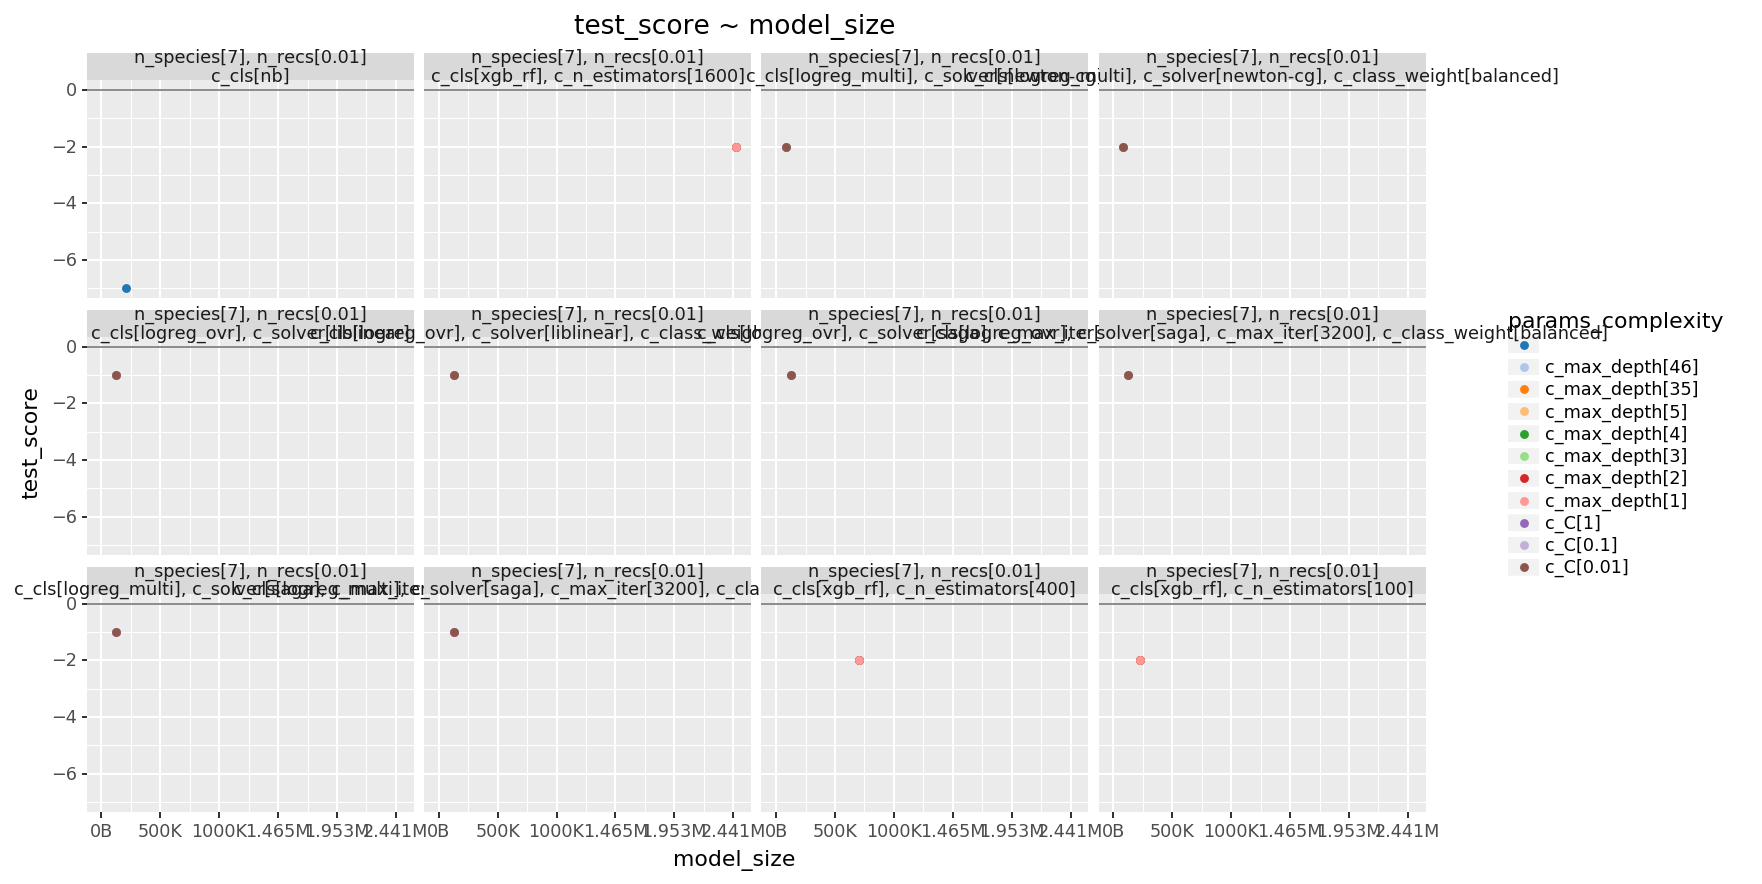

<ggplot: (8746551327240)>

In [ ]:
(cv_models
    .pipe(ggplot)
    + aes(x='model_size', y='test_score')
    + aes(color='params_complexity')
    + facet
    + geom_point()
    + geom_hline(yintercept=0, color='grey')
    + scale_x_continuous(labels=labels_bytes(), breaks=breaks_bytes())
    + expand_limits(x=0)
    # + ylim(-30, 0)
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + guides(color=guide_legend(ncol=1)) + theme(legend_position='right', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize(width=12*1, aspect_ratio=1/1.5)
    + ggtitle('test_score ~ model_size')
)

In [ ]:
# SLOW_PLOTS_NEXT

# Model diagnostics: all models, all folds

In [ ]:
print('models:')
print('  params[*/%s]' % len(cv_models.params.cat.categories))
print('  fold[*/%s]' % cv.cv.n_splits)

models:
  params[*/46]
  fold[*/1]


In [ ]:
# TODO Cache
# Coverage errors: all models, all folds
#   - Subset: all models
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_all_all = (cv_models
    # .sample(n=5, random_state=0)  # For faster dev
    .pipe(lambda df: DF(
        OrderedDict(
            # **row[['model_id', 'params', 'fold']],  # Slow (in this inner loop), unpack manually instead
            model_id=row.model_id,
            params=row.params,
            params_data=row.params_data,
            params_model=row.params_model,
            params_complexity=row.params_complexity,
            params_data_and_model=row.params_data_and_model,
            params_model_and_complexity=row.params_model_and_complexity,
            fold=row.fold,
            i=i,
            y_true=y_true,
            coverage_error=coverage_error,
        )
        for row in iter_progress(df_rows(df), n=len(df))
        for i, y_true, coverage_error in zip(
            row.test_evals.i,
            row.test_evals.y,
            row.test_evals.coverage_errors(),
        )
    ))
    .astype(dict(
        model_id=cv_models.model_id.dtype,
        params=cv_models.params.dtype,
        params_data=cv_models.params_data.dtype,
        params_model=cv_models.params_model.dtype,
        params_complexity=cv_models.params_complexity.dtype,
        params_data_and_model=cv_models.params_data_and_model.dtype,
        params_model_and_complexity=cv_models.params_model_and_complexity.dtype,
    ))
    .pipe(tap, lambda df: display(
        df_summary(df).T,
        df[:10],
    ))
)

  0%|                                                                                                        | 0/46 [00:00<?, ?it/s]

 35%|████████████████████████████████▋                                                             | 16/46 [00:00<00:00, 151.66it/s]

 67%|███████████████████████████████████████████████████████████████▎                              | 31/46 [00:00<00:00, 150.00it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 149.89it/s]

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
model_id,category,342784,2392,2392,46,NaN,NaN,"n_species[7], n_recs[0.01], c_cls[nb], fold[0]","n_species[7], n_recs[0.01], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1],c_class_weight[balanced], fold[0]","n_species[7], n_recs[0.01], c_cls[logreg_multi],c_solver[saga],c_max_iter[3200],c_C[0.1], fold[0]","n_species[7], n_recs[0.01], c_cls[xgb_rf], c_n_estimators[1600], c_max_depth[4], fold[0]","n_species[7], n_recs[0.01], c_cls[xgb_rf], c_n_estimators[100], c_max_depth[1], fold[0]"
params,category,321256,2392,2392,46,NaN,NaN,"n_species[7], n_recs[0.01], c_cls[nb]","n_species[7], n_recs[0.01], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1],c_class_weight[balanced]","n_species[7], n_recs[0.01], c_cls[logreg_multi],c_solver[saga],c_max_iter[3200],c_C[0.1]","n_species[7], n_recs[0.01], c_cls[xgb_rf], c_n_estimators[1600], c_max_depth[4]","n_species[7], n_recs[0.01], c_cls[xgb_rf], c_n_estimators[100], c_max_depth[1]"
params_data,category,179400,2392,2392,1,NaN,NaN,"n_species[7], n_recs[0.01]","n_species[7], n_recs[0.01]","n_species[7], n_recs[0.01]","n_species[7], n_recs[0.01]","n_species[7], n_recs[0.01]"
params_model,category,681616,2392,2392,12,NaN,NaN,c_cls[nb],"c_cls[logreg_multi], c_solver[newton-cg], c_class_weight[balanced]","c_cls[logreg_ovr], c_solver[saga], c_max_iter[3200]","c_cls[xgb_rf], c_n_estimators[400]","c_cls[xgb_rf], c_n_estimators[100]"
params_complexity,category,252616,2392,2392,11,NaN,NaN,,c_max_depth[4],c_C[1],c_C[0.1],c_C[0.01]
params_data_and_model,category,292760,2392,2392,12,NaN,NaN,"n_species[7], n_recs[0.01]\nc_cls[nb]","n_species[7], n_recs[0.01]\nc_cls[logreg_multi], c_solver[newton-cg], c_class_weight[balanced]","n_species[7], n_recs[0.01]\nc_cls[logreg_ovr], c_solver[saga], c_max_iter[3200]","n_species[7], n_recs[0.01]\nc_cls[xgb_rf], c_n_estimators[400]","n_species[7], n_recs[0.01]\nc_cls[xgb_rf], c_n_estimators[100]"
params_model_and_complexity,category,255736,2392,2392,46,NaN,NaN,c_cls[nb]\n,"c_cls[logreg_multi], c_solver[newton-cg], c_class_weight[balanced]\nc_C[1]","c_cls[logreg_ovr], c_solver[saga], c_max_iter[3200]\nc_C[0.01]","c_cls[xgb_rf], c_n_estimators[400]\nc_max_depth[5]","c_cls[xgb_rf], c_n_estimators[100]\nc_max_depth[1]"
fold,int64,57408,2392,2392,1,0.000,0.000,0,0,0,0,0
i,int64,66976,2392,2392,52,27407.654,14969.515,1890,13220,25564,42056,51425


,model_id,params,params_data,params_model,params_complexity,params_data_and_model,params_model_and_complexity,fold,i,y_true,coverage_error
0,"n_species[7], n_recs[0.01], c_cls[nb], fold[0]","n_species[7], n_recs[0.01], c_cls[nb]","n_species[7], n_recs[0.01]",c_cls[nb],,"n_species[7], n_recs[0.01]\nc_cls[nb]",c_cls[nb]\n,0,34781,WEWP,1.0
1,"n_species[7], n_recs[0.01], c_cls[nb], fold[0]","n_species[7], n_recs[0.01], c_cls[nb]","n_species[7], n_recs[0.01]",c_cls[nb],,"n_species[7], n_recs[0.01]\nc_cls[nb]",c_cls[nb]\n,0,50535,WEWP,7.0
2,"n_species[7], n_recs[0.01], c_cls[nb], fold[0]","n_species[7], n_recs[0.01], c_cls[nb]","n_species[7], n_recs[0.01]",c_cls[nb],,"n_species[7], n_recs[0.01]\nc_cls[nb]",c_cls[nb]\n,0,9375,WEWP,7.0
3,"n_species[7], n_recs[0.01], c_cls[nb], fold[0]","n_species[7], n_recs[0.01], c_cls[nb]","n_species[7], n_recs[0.01]",c_cls[nb],,"n_species[7], n_recs[0.01]\nc_cls[nb]",c_cls[nb]\n,0,25144,AMAV,7.0
4,"n_species[7], n_recs[0.01], c_cls[nb], fold[0]","n_species[7], n_recs[0.01], c_cls[nb]","n_species[7], n_recs[0.01]",c_cls[nb],,"n_species[7], n_recs[0.01]\nc_cls[nb]",c_cls[nb]\n,0,3451,COHU,1.0
5,"n_species[7], n_recs[0.01], c_cls[nb], fold[0]","n_species[7], n_recs[0.01], c_cls[nb]","n_species[7], n_recs[0.01]",c_cls[nb],,"n_species[7], n_recs[0.01]\nc_cls[nb]",c_cls[nb]\n,0,24038,AMAV,7.0
6,"n_species[7], n_recs[0.01], c_cls[nb], fold[0]","n_species[7], n_recs[0.01], c_cls[nb]","n_species[7], n_recs[0.01]",c_cls[nb],,"n_species[7], n_recs[0.01]\nc_cls[nb]",c_cls[nb]\n,0,20738,AMAV,7.0
7,"n_species[7], n_recs[0.01], c_cls[nb], fold[0]","n_species[7], n_recs[0.01], c_cls[nb]","n_species[7], n_recs[0.01]",c_cls[nb],,"n_species[7], n_recs[0.01]\nc_cls[nb]",c_cls[nb]\n,0,10017,WEWP,1.0
8,"n_species[7], n_recs[0.01], c_cls[nb], fold[0]","n_species[7], n_recs[0.01], c_cls[nb]","n_species[7], n_recs[0.01]",c_cls[nb],,"n_species[7], n_recs[0.01]\nc_cls[nb]",c_cls[nb]\n,0,30065,WEWP,7.0
9,"n_species[7], n_recs[0.01], c_cls[nb], fold[0]","n_species[7], n_recs[0.01], c_cls[nb]","n_species[7], n_recs[0.01]",c_cls[nb],,"n_species[7], n_recs[0.01]\nc_cls[nb]",c_cls[nb]\n,0,45290,WEWP,7.0


In [ ]:
[print(x) for x in coverage_errors_all_all.params_data.unique()];
params_data = (
    'n_species[168], n_recs[1.0]'
    # 'n_species[336], n_recs[1.0]'
    # 'n_species[159], n_recs[1.0]'
)
n_species = parse.search('n_species[{n_species:d}], n_recs[{n_recs:f}]', params_data)['n_species']

n_species[7], n_recs[0.01]


In [ ]:
# TODO Class imbalance
#   1. Is class imbalance causing a problem? [-> maybe]
#   2. Is class_weight solving it? [-> maybe a little bit]
#   - TODO Try again with larger class imbalance
(coverage_errors_all_all
    [lambda df: df.params_data == params_data]
    # .sample(100, random_state=0)  # Faster dev
    .merge(how='left', on='y_true', right=(recs
        .assign(n_recs=1).groupby('species')['n_recs'].sum().reset_index()
        .rename(columns={'species': 'y_true'})
    ))
    # .pipe(puts, f=lambda df: df[:3])  # XXX Debug
    .pipe(ggplot)
    # + facet_grid('params_complexity ~ params_model')
    + facet_wrap('params_model_and_complexity')
    + aes(x='n_recs', y='coverage_error')
    + geom_count(aes(size='..n..')) + scale_size_area()
    + expand_limits(x=0, y=0)
    + coord_flip()
    + theme_figsize(width=12*1, aspect_ratio=1/1)
    + ggtitle(rf'Coverage error by n_recs per species ({recs_stats}) [{params_data}]')
)

/opt/conda/lib/python3.6/site-packages/prettyprinter/prettyprinter.py:341: UserWarning: The pretty printer for ggplot, prettyprinter.prettyprinter._repr_pretty, raised an exception. Falling back to default repr.

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/prettyprinter/prettyprinter.py", line 381, in _run_pretty
    doc = pretty_fn(value, ctx)
  File "/opt/conda/lib/python3.6/site-packages/prettyprinter/prettyprinter.py", line 419, in _repr_pretty
    return repr(value)
  File "/opt/conda/lib/python3.6/site-packages/plotnine/ggplot.py", line 97, in __repr__
    self.draw()
  File "/opt/conda/lib/python3.6/site-packages/plotnine/ggplot.py", line 190, in draw
    return self._draw(return_ggplot)
  File "/opt/conda/lib/python3.6/site-packages/plotnine/ggplot.py", line 197, in _draw
    self._build()
  File "/opt/conda/lib/python3.6/site-packages/plotnine/ggplot.py", line 290, in _build
    layout.setup(layers, self)
  File "/opt/conda/lib/python3.6/s

PlotnineError: 'Faceting variables must have at least one value'

In [ ]:
# Facet by params_no_ns, order by median(coverage_error)
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
(coverage_errors_all_all
    [lambda df: df.params_data == params_data]
    # .sample(100, random_state=0)  # Faster dev
    # .pipe(df_reverse_cat, 'params', 'params_no_ns', 'ns')
    .pipe(df_ordered_cat,
        y_true=lambda df: (
            # Sort species by median(coverage_error) (across all models)
            df.groupby('y_true').agg({'coverage_error': np.median}).reset_index().sort_values('coverage_error').y_true
            # Sort species by taxo (hard to compare across models, unless they're pretty low noise)
            # reversed(recs.species.cat.categories)
        ),
    )
    .pipe(ggplot)
    + aes(x='y_true', y='coverage_error')
    + aes(color='y_true')
    # + facet_grid('params_complexity ~ params_model')
    + facet_wrap('params_model_and_complexity', dir='v',
        nrow=coverage_errors_all_all.params_model.nunique(),  # Bug: nrow instead of ncol [https://github.com/has2k1/plotnine/issues/163]
    )
    # + geom_line(aes(group='params'), stat='summary', fun_y=np.median)  # TODO Bad interpolation with n_species
    + geom_point(aes(group='params'), stat='summary', fun_y=np.median)
    + coord_flip()
    # + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + scale_color_cmap_d(mpl_cmap_repeat(10, 'tab20', 'tab20b', 'tab20c'))
    + theme_minimal()  # Before other theme()
    + guides(color=guide_legend(nrow=70))
    + theme(legend_position='right', legend_box_spacing=.4, legend_key_height=8, legend_text=element_text(size=8))
    + theme(axis_text_y=element_blank())
    + theme_figsize(width=12*1, aspect_ratio=1/2)
    + ggtitle(rf'Coverage error over fold $\times$ instance ({recs_stats}) [{params_data}]')
)

/opt/conda/lib/python3.6/site-packages/prettyprinter/prettyprinter.py:341: UserWarning: The pretty printer for ggplot, prettyprinter.prettyprinter._repr_pretty, raised an exception. Falling back to default repr.

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/prettyprinter/prettyprinter.py", line 381, in _run_pretty
    doc = pretty_fn(value, ctx)
  File "/opt/conda/lib/python3.6/site-packages/prettyprinter/prettyprinter.py", line 419, in _repr_pretty
    return repr(value)
  File "/opt/conda/lib/python3.6/site-packages/plotnine/ggplot.py", line 97, in __repr__
    self.draw()
  File "/opt/conda/lib/python3.6/site-packages/plotnine/ggplot.py", line 190, in draw
    return self._draw(return_ggplot)
  File "/opt/conda/lib/python3.6/site-packages/plotnine/ggplot.py", line 197, in _draw
    self._build()
  File "/opt/conda/lib/python3.6/site-packages/plotnine/ggplot.py", line 290, in _build
    layout.setup(layers, self)
  File "/opt/conda/lib/python3.6/s

PlotnineError: 'Faceting variables must have at least one value'

In [ ]:
# TODO Slow, bad for notebook dev loop -- move lower, or disable by default?
# Facet by species
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
[print(x) for x in coverage_errors_all_all.params_model.unique()];
params_model = [
    # 'c_cls[rf], c_n_estimators[100]',
    # 'c_cls[logreg_multi], c_solver[newton-cg]',
    # 'c_cls[logreg_ovr], c_solver[liblinear]',
    # 'c_cls[xgb_rf], c_n_estimators[100]',
    # 'c_cls[logreg_ovr], c_solver[liblinear], c_C[0.1]',
    'c_cls[nb]',
]
(coverage_errors_all_all
    [lambda df: df.params_data == params_data]
    [lambda df: df.params_model.isin(params_model)]
    # .sample(200, random_state=0)  # Faster dev
    # [lambda df: df.y_true.isin(df.y_true.drop_duplicates().sample(n=3, random_state=0))]  # Faster dev
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    # .pipe(df_reverse_cat, 'params_complexity')
    .pipe(ggplot)
    + aes(x='params_complexity', y='coverage_error')
    + aes(color='params_complexity')
    + facet_wrap('y_true',
        ncol=int((n_species * 1/(2/3)) ** .5),
    )
    + geom_hline(yintercept=1, color='grey')
    # + geom_hline(yintercept=recs.species.nunique(), color='grey')
    # Percentiles (faster, no overplot)
    # + geom_point(stat='summary', fun_y=np.median)
    # + geom_linerange(stat='summary', fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75))
    # Violin (slow, no overplot)
    # + geom_violin()
    # Boxplot (very slow, no overplot)
    # + geom_boxplot()
    # Points (medium cost, high overplot)
    #   - n (count) instead of prop (proportion)
    #   - scale_size_area() instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_count(aes(size='..n..'), color='lightgray')
    + scale_size_area()
    # + geom_point(stat='summary', fun_y=np.median, shape='|', size=5, stroke=2)
    + geom_point(stat='summary', fun_y=np.median, size=5)
    + coord_flip(
        # ylim=(0, 40),
    )
    # + scale_color_cmap_d(mpl_cmap_repeat(10, 'tab10'))  # Strong
    + scale_color_cmap_d(mpl_cmap_repeat(1, 'tab20', 'tab20b', 'tab20c'))  # FIXME repeat(10) makes lots of blue/gray
    + guides(color=guide_legend(reverse=True))
    + theme(axis_text_y=element_text(size=6))
    + theme_minimal()  # [TODO Before other theme()]
    + theme_figsize(width=12*2, aspect_ratio=1/1)
    + ggtitle(rf'Coverage error over fold $\times$ instance, by params_complexity ({recs_stats}) [{params_data}, {params_model}]')
)

c_cls[nb]
c_cls[xgb_rf], c_n_estimators[1600]
c_cls[logreg_multi], c_solver[newton-cg]
c_cls[logreg_multi], c_solver[newton-cg], c_class_weight[balanced]
c_cls[logreg_ovr], c_solver[liblinear]
c_cls[logreg_ovr], c_solver[liblinear], c_class_weight[balanced]
c_cls[logreg_ovr], c_solver[saga], c_max_iter[3200]
c_cls[logreg_ovr], c_solver[saga], c_max_iter[3200], c_class_weight[balanced]
c_cls[logreg_multi], c_solver[saga], c_max_iter[3200]
c_cls[logreg_multi], c_solver[saga], c_max_iter[3200], c_class_weight[balanced]
c_cls[xgb_rf], c_n_estimators[400]
c_cls[xgb_rf], c_n_estimators[100]


/opt/conda/lib/python3.6/site-packages/prettyprinter/prettyprinter.py:341: UserWarning: The pretty printer for ggplot, prettyprinter.prettyprinter._repr_pretty, raised an exception. Falling back to default repr.

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/prettyprinter/prettyprinter.py", line 381, in _run_pretty
    doc = pretty_fn(value, ctx)
  File "/opt/conda/lib/python3.6/site-packages/prettyprinter/prettyprinter.py", line 419, in _repr_pretty
    return repr(value)
  File "/opt/conda/lib/python3.6/site-packages/plotnine/ggplot.py", line 97, in __repr__
    self.draw()
  File "/opt/conda/lib/python3.6/site-packages/plotnine/ggplot.py", line 190, in draw
    return self._draw(return_ggplot)
  File "/opt/conda/lib/python3.6/site-packages/plotnine/ggplot.py", line 197, in _draw
    self._build()
  File "/opt/conda/lib/python3.6/site-packages/plotnine/ggplot.py", line 290, in _build
    layout.setup(layers, self)
  File "/opt/conda/lib/python3.6/s

PlotnineError: 'Faceting variables must have at least one value'

In [ ]:
# TODO Slow, bad for notebook dev loop -- move lower, or disable by default?
# Facet by species
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
[print(x) for x in coverage_errors_all_all.params_complexity.unique()];
params_complexity = [
    # 'c_max_depth[46]',
    # 'c_max_depth[1]',
    # 'c_C[0.01]',
    # 'c_class_weight[balanced]',
    '',
]
(coverage_errors_all_all
    [lambda df: df.params_data == params_data]
    [lambda df: df.params_complexity.isin(params_complexity)]
    # [lambda df: df.params.astype(str).str.contains(r'c_n_estimators\[100\]')]  # XXX Subset models
    # .sample(200, random_state=0)  # Faster dev
    # [lambda df: df.y_true.isin(df.y_true.drop_duplicates().sample(n=3, random_state=0))]  # Faster dev
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    # .pipe(df_reverse_cat, 'params_model')
    .pipe(ggplot)
    + aes(x='params_model', y='coverage_error')
    + aes(color='params_model')
    + facet_wrap('y_true',
        ncol=int((n_species * 1/(2/3)) ** .5),
    )
    + geom_hline(yintercept=1, color='grey')
    # + geom_hline(yintercept=recs.species.nunique(), color='grey')
    # Percentiles (faster, no overplot)
    # + geom_point(stat='summary', fun_y=np.median)
    # + geom_linerange(stat='summary', fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75))
    # Violin (slow, no overplot)
    # + geom_violin()
    # Boxplot (very slow, no overplot)
    # + geom_boxplot()
    # Points (medium cost, high overplot)
    #   - n (count) instead of prop (proportion)
    #   - scale_size_area() instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_count(aes(size='..n..'), color='lightgray')
    + scale_size_area()
    # + geom_point(stat='summary', fun_y=np.median, shape='|', size=5, stroke=2)
    + geom_point(stat='summary', fun_y=np.median, size=5)
    + coord_flip(
        ylim=(0, 40),
    )
    + scale_color_cmap_d(mpl_cmap_repeat(1, 'tab20', 'tab20b', 'tab20c'))  # FIXME repeat(10) makes lots of blue/gray
    + guides(color=guide_legend(reverse=True))
    + theme(axis_text_y=element_text(size=6))
    + theme_minimal()  # [TODO Before other theme()]
    + theme_figsize(width=12*2, aspect_ratio=1/1)
    + ggtitle(rf'Coverage error over fold $\times$ instance, by params_model ({recs_stats}) [{params_data}, {params_complexity}]')
)


c_max_depth[46]
c_C[0.01]
c_C[0.1]
c_C[1]
c_max_depth[35]
c_max_depth[5]
c_max_depth[4]
c_max_depth[3]
c_max_depth[2]
c_max_depth[1]


/opt/conda/lib/python3.6/site-packages/prettyprinter/prettyprinter.py:341: UserWarning: The pretty printer for ggplot, prettyprinter.prettyprinter._repr_pretty, raised an exception. Falling back to default repr.

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/prettyprinter/prettyprinter.py", line 381, in _run_pretty
    doc = pretty_fn(value, ctx)
  File "/opt/conda/lib/python3.6/site-packages/prettyprinter/prettyprinter.py", line 419, in _repr_pretty
    return repr(value)
  File "/opt/conda/lib/python3.6/site-packages/plotnine/ggplot.py", line 97, in __repr__
    self.draw()
  File "/opt/conda/lib/python3.6/site-packages/plotnine/ggplot.py", line 190, in draw
    return self._draw(return_ggplot)
  File "/opt/conda/lib/python3.6/site-packages/plotnine/ggplot.py", line 197, in _draw
    self._build()
  File "/opt/conda/lib/python3.6/site-packages/plotnine/ggplot.py", line 290, in _build
    layout.setup(layers, self)
  File "/opt/conda/lib/python3.6/s

PlotnineError: 'Faceting variables must have at least one value'

In [ ]:
# ONE_MODEL_PLOTS_NEXT

# Model diagnostics: one model, all folds

In [ ]:
params_i = 0
params = cv_models.params.cat.categories[params_i]
print("params:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(cv_models.params.cat.categories)))
print()
print('models:')
print('  params[%s/%s]: %r' % (params_i, len(cv_models.params.cat.categories), params))
print('  fold[*/%s]' % cv.cv.n_splits)

params:
  0: 'n_species[7], n_recs[0.01], c_cls[nb]'
  1: 'n_species[7], n_recs[0.01], c_cls[xgb_rf], c_n_estimators[1600], c_max_depth[46]'
  2: 'n_species[7], n_recs[0.01], c_cls[logreg_multi],c_solver[newton-cg],c_C[0.01]'
  3: 'n_species[7], n_recs[0.01], c_cls[logreg_multi],c_solver[newton-cg],c_C[0.01],c_class_weight[balanced]'
  4: 'n_species[7], n_recs[0.01], c_cls[logreg_multi],c_solver[newton-cg],c_C[0.1]'
  5: 'n_species[7], n_recs[0.01], c_cls[logreg_multi],c_solver[newton-cg],c_C[0.1],c_class_weight[balanced]'
  6: 'n_species[7], n_recs[0.01], c_cls[logreg_multi],c_solver[newton-cg],c_C[1]'
  7: 'n_species[7], n_recs[0.01], c_cls[logreg_multi],c_solver[newton-cg],c_C[1],c_class_weight[balanced]'
  8: 'n_species[7], n_recs[0.01], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01]'
  9: 'n_species[7], n_recs[0.01], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.01],c_class_weight[balanced]'
  10: 'n_species[7], n_recs[0.01], c_cls[logreg_ovr],c_solver[liblinear],c_C[0.1]'
  11: 'n

In [ ]:
# Coverage errors: one model, all folds
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
% {time: 2.544s}
overage_errors_one_all = (coverage_errors_all_all
    [lambda df: df.params == params]  # One model, all folds
)
display(
    df_summary(coverage_errors_one_all).T,
    coverage_errors_one_all[:5],
)

UsageError: Line magic function `%{time:` not found.


In [ ]:
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i].groupby(y_true) for model)
#       - Over: fold, rec_id
#   - Dims: y_true
#   - Metrics: count, coverage_error.percentiles
# in: coverage_errors_one_all, recs
(coverage_errors_one_all
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_reverse_cat, 'y_true')
    .pipe(ggplot, aes(x='y_true', y='coverage_error'))
    + geom_hline(yintercept=1, color='grey')
    + geom_hline(yintercept=10, color='grey')
    + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + geom_count(aes(size='..n..'), alpha=1)  # n (count) instead of prop (proportion)
    + scale_size_area()  # Instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_point(stat='summary', fun_y=np.median, alpha=1, color='red', shape='|', size=6, stroke=2)
    + coord_flip()
% {time: 2.393s}
   # + theme_figsize('inline')
    # + theme_figsize('square')
    # + theme_figsize('half')
    + theme_figsize('half_dense')
    # + theme_figsize('full')
    # + theme_figsize('full_dense')
    + ggtitle(rf'Coverage error over fold $\times$ instance ({params}) ({recs_stats})')
)

SyntaxError: invalid syntax (<ipython-input-113-c8015b1de8a7>, line 18)

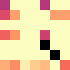

In [ ]:
# One-model/all-folds confusion matrix
with figsize(
    # 'square',
    # 'full',
    'full_dense',
):
    (cv_models
        [lambda df: df.params == params]
        .pipe(lambda df: plot_confusion_matrix(
            classes=df.iloc[0].test_evals.classes,
            M=np.array([
                row.test_evals.confusion_matrix_prob()
                for row in df_rows(df)
            ]).sum(axis=0),
            # normalize=False,  # For counts
            raw=True, scale=10,  # Faster dev
            format=None,  # Omit numbers, too dense
            title=f'({recs_stats})',
        ))
    )

# Model diagnostics: one model, one fold

In [ ]:
fold = 0
# params_i = ...  # Comment out to reuse from above
params = cv_models.params.cat.categories[params_i]
[(_, model)] = list(cv_models[lambda df: (df.params == params) & (df.fold == fold)].iterrows())
print("params:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(cv_models.params.cat.categories)))
print()
print('model:')
print('  params[%s/%s]: %r' % (params_i, len(cv_models.params.cat.categories), model.params))
print('  fold[%s/%s]' % (model.fold, cv.cv.n_splits))
print()
print(model)

[skip]

In [ ]:
# in: model
model_id = model.model_id
params = model.params
fold = model.fold
# train_evals = model.train_evals
test_evals = model.test_evals

# in: model, recs
# train_recs = recs.iloc[train_evals.i]
# train_X = Search.X(recs)[train_evals.i]
# train_y = Search.y(recs)[train_evals.i]
test_recs = recs.iloc[test_evals.i]
test_X = Search.X(recs)[test_evals.i]
test_y = Search.y(recs)[test_evals.i]  # (Don't need to store cv_models.test_evals.y if we have recs -- which sometimes we don't?)

display(
    # len(train_recs),
    len(test_recs),
)

[skip]

In [ ]:
# TODO Restore this plot like 'Coverage error over ...' above, so we can see _one_ model instead of aggregating over n_splits models
# # TODO Update [kill the .merge, then species -> y_true]
# (search.coverage_error_by(test_recs, 'id')
#     [:5]
#     # .merge(test_recs[['id', 'species']], on='id', how='left')
#     # .pipe(ggplot, aes(x='species', y='coverage_error'))
#     # + geom_count(aes(size='..n..'))
#     # + stat_summary(fun_y=np.median, geom='point', color='red', alpha=.5, shape='|', size=6, stroke=1)
#     # + stat_summary(
#     #     fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75),
#     #     geom='linerange', color='red', alpha=.5, size=1,
#     # )
#     # + coord_flip()
#     # + geom_hline(yintercept=len(search.classes_), color='grey')
#     # + scale_x_discrete(limits=list(reversed(test_recs.species.cat.categories)))
#     # + theme_figsize('square')
#     # + ggtitle(rf'Coverage error over instance ({model_id}) ({recs_stats})')
# )

[skip]

In [ ]:
# One-model/one-fold confusion matrix
with figsize(
    'square',
    # 'full',
    # 'full_dense',
):
    plot_confusion_matrix_df(
        confusion_matrix_prob_df(model.test_evals.y, model.test_evals.y_scores, model.test_evals.classes),
        title=model.model_id,
        # normalize=False,  # For counts
        raw=True, scale=10,  # Faster dev
        title=f'({recs_stats})',
    )

[skip]

In [ ]:
DEBUG_PLOTS_NEXT

# Debug plots, ignored by default

## Debug: resource usage

In [ ]:
(cv_models
    .pipe(df_reverse_cat, 'params', 'params_no_ns', 'ns')
    # Manually compute y.mean() per group
    .groupby('params').apply(lambda g: g.assign(mem_rss_delta_mean=lambda df: df.mem_rss_delta.mean()))
    .pipe(ggplot, aes(x='ns', group='params_no_ns'))
    + geom_col(aes(y='mem_rss_delta_mean', fill='params_no_ns'), position=position_dodge()) # Summary per fold
    + geom_point(aes(y='mem_rss_delta'), fill='none', size=2, position=position_dodge(width=.9)) # Distribution of folds
    + coord_flip()
    + scale_fill_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + scale_y_continuous(labels=labels_bytes(), breaks=breaks_bytes())
    + guides(fill=guide_legend(reverse=True))
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize(aspect_ratio=1/3*2)
    + ggtitle(f'Mem rss spread ($max-min$) ({recs_stats})')
)

In [ ]:
# TODO Very slow with ~200 models
cv_models_proc_stats = (cv_models
    # Enable these as needed (at the cost of mem usage)
    [[
        'model_id',
        'params',
        # 'params_dict',
        'params_data',
        'params_complexity',
        'params_model',
        'fold',
        # 'train_score',
        # 'test_score',
        # 'fit_time',
        # 'score_time',
        'mem_rss_delta',
        # 'mem_vms_delta',
        # 'train_evals',
        # 'test_evals',
        'proc_stats',
    ]]
    # TODO Faster way to do this? (.merge is >2x slower)
    .pipe(df_flatmap, lambda row: [
        row.append(pd.Series(dict(**stats)))
        for stats in row.proc_stats.stats
    ])
    # .pipe(lambda df: (df
    #     .merge(how='left',
    #         right=DF(
    #             OrderedDict(model_id=row.model_id, **stats)
    #             for row in df_rows(df)
    #             for stats in row.proc_stats.stats
    #         )
    #     )
    # ))
    # HACK Restore the cats that the df_flatmap just destroyed [copied from cv_results_splits_df]
    .pipe(df_ordered_cat,
        model_id=lambda df: df.model_id.unique(),
        params=lambda df: df.params.unique(),
    )
    .assign(
        cpu_user=lambda df: df.cpu_user.diff() * 100,
        cpu_system=lambda df: df.cpu_system.diff() * 100,
    )
    .pipe(tap, f=lambda df: display(
        df_summary(df).T,
        df[:5],
    ))
)

In [ ]:
# TODO Might need to stack/geom_area for overlapping runs
(cv_models_proc_stats
    .pipe(ggplot)
    + aes(x='time', color='model_id')
    + geom_line(aes(y='cpu_system'), linetype='dashed', size=.5)
    + geom_line(aes(y='cpu_system + cpu_user'), linetype='solid', size=.5)
    + expand_limits(y=0)
    + ylab('cpu')
    + scale_x_datetime(date_labels='%H:%M:%S')
    + scale_y_continuous(labels=lambda labels: ['%.3g%%' % x for x in labels])
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize('inline_short')
    + ggtitle('cpu over time (system + user)')
)

In [ ]:
(cv_models_proc_stats
    .pipe(ggplot)
    + aes(x='time', color='model_id')
    + geom_line(aes(y='mem_rss'), linetype='solid', size=.5)
    + geom_line(aes(y='mem_vms'), linetype='dashed', size=.5)
    + expand_limits(y=0)
    + ylab('mem')
    + scale_x_datetime(date_labels='%H:%M:%S')
    + scale_y_continuous(labels=labels_bytes(), breaks=breaks_bytes(pow=3))
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize('inline_short')
    + ggtitle('Mem over time (rss, vms)')
)

## Debug: RF tuning

In [ ]:
# TODO Revive if insightful
(cv_models
    .pipe(df_reverse_cat, 'params_no_ns')
    .assign(n_species=lambda df: df.params_dict.str['n_species'])
    .pipe(ggplot, aes(x='n_species', y='forest_depth_mean', color='params_no_ns'))
    # + facet_wrap('params_no_ns', ncol=2)
    + geom_point()
    + geom_pointrange(aes(ymin='forest_depth_mean - 2*forest_depth_std', ymax='forest_depth_mean + 2*forest_depth_std'))
    + geom_smooth(method='lm', se=False)  # Disable se because it only knows forest_depth_mean, no measure of spread
    + expand_limits(x=0)
    + scale_color_cmap_d(mpl_cmap_concat('tab20', 'tab20b', 'tab20c'))
    + guides(color=guide_legend(reverse=True))
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    # + theme_figsize(aspect_ratio=1/3)
    + theme_figsize(aspect_ratio=1/3)
    + ggtitle(f'RF depth vs. n_species ({recs_stats})')
)